### Classifcation Module

In [2]:
from tensorflow import keras
import tensorflow as tf

import numpy as np
from PIL import Image

2024-01-05 23:06:48.666688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# load model
model = keras.models.load_model('Models/model.h5')
print(model)

In [4]:
classes = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [5]:
img_height = 180
img_width = 180

In [6]:
# Image verification
def verify(image_path):
    image = Image.open(image_path)
    image = image.resize((180, 180))
    image_pixels = list(image.getdata())
    green_pixels = [pixel for pixel in image_pixels if pixel[1] > 200]
    if len(green_pixels) > 0:
        return True
    else:
        return 'Invalid Image'

In [7]:
def predict(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    label = classes[np.argmax(score)]
    confidence = 100 * np.max(score)

    return label, confidence

In [8]:
path1 = 'test.jpeg'
path2 = 'test2.jpeg'

In [10]:
if verify(path1) == True:
    label, confidence = predict(path1)
    print(label, round(confidence, 2))
else:
    print(verify(path1))

1/1 [==============================] - 0s 45ms/step
Blight 78.46


### Segmentation Module

In [12]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

import cv2

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [13]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.1.2
Torchvision version: 0.16.2
CUDA is available: False


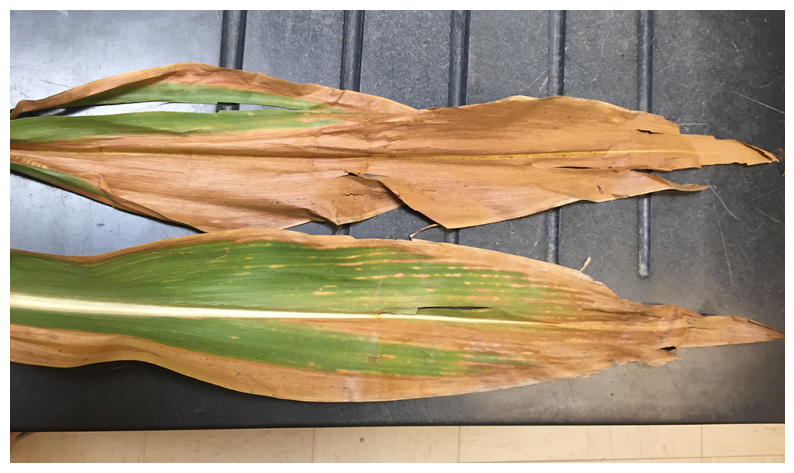

In [14]:
image = cv2.imread(path1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [17]:
sam_checkpoint = "Models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [18]:
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [19]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.99,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator_.generate(image)

In [20]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

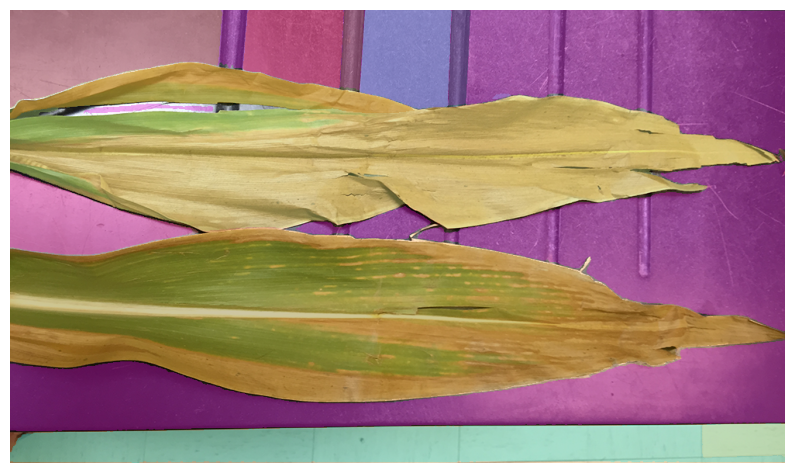

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
def verify_seg(label):
    if label != 'Healthy':
        return True
    else:
        return False

### Combined Module